# Lesson 13, Workalong 01: Finding Earthquakes in California

This workalong uses `geopandas` to find earthquakes within California.  It builds from the [lesson 05 warmup](https://github.com/taobrienlbl/advanced_earth_science_data_analysis/blob/8fdbb61bc39b64244f420d446b985a4d27f80df6/lessons/05_multidimensional_arrays_also_plotting/05_warmup_SOLUTION.ipynb), in which we used pandas to find earthquakes from a USGS dataset.  We'll use a similar approach to initially load the same dataset.

In [1]:
""" Import libraries """
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy

In [2]:
""" Load the usgs dataset """

dataset_path = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/1cc2bc06219f7c15b211629a2aeba7d57e783138/lessons/05_multidimensional_arrays_also_plotting/data/usgs_major_earthquakes_1900-2023.csv"

# use pandas to read the dataset
usgs_pd = pd.read_csv(
    dataset_path,
    header=0,
    parse_dates=[0],
    )

# show the top of the dataset
usgs_pd.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-09-21 21:11:49.950000+00:00,-14.0039,167.1898,188.419,6.1,mww,76.0,26.0,7.076,0.83,...,2023-09-21T23:17:30.631Z,"41 km WSW of Sola, Vanuatu",earthquake,8.86,4.898,0.054,33.0,reviewed,us,us
1,2023-09-20 14:45:58.609000+00:00,-4.5826,-105.6493,10.000,6.0,mww,110.0,208.0,15.828,1.08,...,2023-09-21T21:02:41.950Z,central East Pacific Rise,earthquake,14.99,1.952,0.050,38.0,reviewed,us,us
2,2023-09-18 13:21:23.790000+00:00,26.4336,125.3032,183.483,6.3,mww,113.0,35.0,2.262,1.21,...,2023-09-19T13:29:35.504Z,"180 km N of Hirara, Japan",earthquake,6.53,4.942,0.044,49.0,reviewed,us,us
3,2023-09-13 11:49:15.926000+00:00,-36.2201,-97.9378,10.000,6.1,mww,117.0,37.0,13.309,0.65,...,2023-09-14T11:52:11.466Z,West Chile Rise,earthquake,10.28,1.860,0.050,39.0,reviewed,us,us
4,2023-09-12 11:03:18.873000+00:00,19.2687,121.2178,41.281,6.3,mww,133.0,21.0,4.049,0.96,...,2023-09-18T13:59:24.715Z,"73 km N of Namuac, Philippines",earthquake,8.03,5.112,0.046,46.0,reviewed,us,us


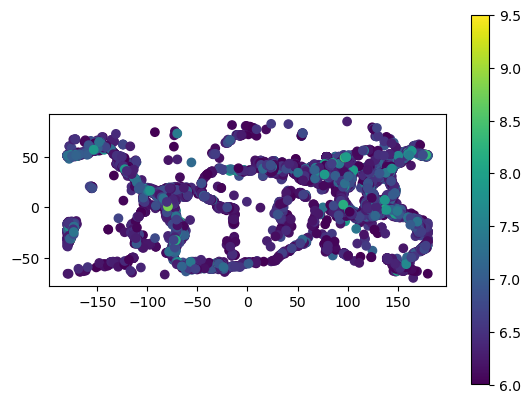

In [3]:
""" Convert the pandas dataframe into a geodataframe """

# convert the pandas dataframe into a geodataframe
usgs_gdf = gpd.GeoDataFrame(
    usgs_pd,
    geometry=gpd.points_from_xy(
        usgs_pd.longitude,
        usgs_pd.latitude,
        ),
    crs="EPSG:4326", # this is the coordinate reference system for lat/lon
    )

# plot the dataframe
usgs_gdf.plot(column = "mag", legend=True);

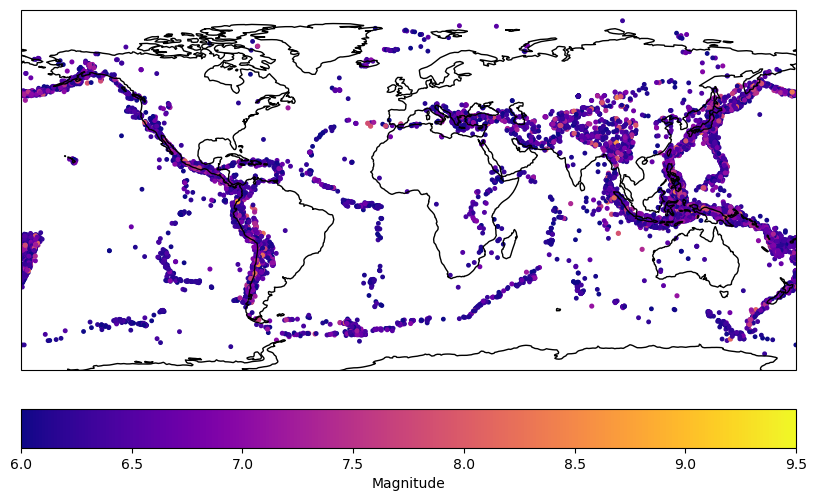

In [4]:
""" Plot the earthquakes by magnitude """

projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": projection})

# convert the projection to a PROJ4 string (used for converting data to the map's projection)
ax_proj = ax.projection.proj4_init

# convert the geodataframe to the projection of the map
usgs_gdf_projected = usgs_gdf.to_crs(ax_proj)

# generate a scatter plot where symbol size is based on magnitude
usgs_gdf_projected.plot(
    ax=ax,
    column="mag",
    markersize=usgs_gdf.mag,
    legend=True,
    transform=cartopy.crs.PlateCarree(),
    cmap = "plasma",
    legend_kwds=dict(label="Magnitude", orientation="horizontal",pad=0.05),
    )

# add geographic features
ax.coastlines()

plt.show()

## State boundaries

The next step involves filtering by state.  While technically we might be able to determine the location using the "place" column in the dataset, we can do better than that by using a shapefile to define the geospatial region we want to search and then using a point-in-polygon method to find earthquake points taht are within that region.

Note that this shapefile dataset was downloaded from  https://www.sciencebase.gov/catalog/item/52c78623e4b060b9ebca5be5 on Tuesday November 28, 2023 at 1:45pm Eastern.

In [5]:
""" Load the state boundary shapefile. """

# set the path to the shapefile
state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"

# load the state boundary shapefile
state_boundary_gdf = gpd.read_file(state_shapefile_path)

# plot the state boundary shapefile
state_boundary_gdf.head()


,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


Since this is a dataframe, we can use pandas features to select rows.  I'm going to pull the row where the "STUSPS" column is "CA".

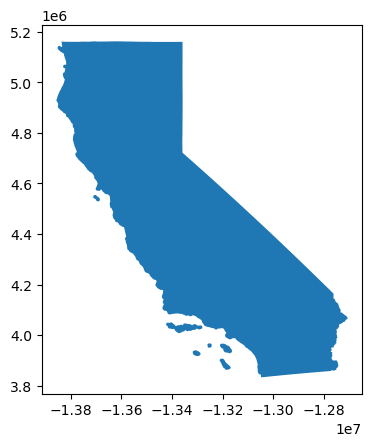

In [6]:
""" Extract the CA row. """
# extract the CA row
ca_boundary_gdf = state_boundary_gdf[state_boundary_gdf.STUSPS == "CA"]

# plot the CA boundary
ca_boundary_gdf.plot();

This particular shapefile seems to include coastal waters that are also part of the state (note how the islands look like dots).  That might not be great for some analyses, but for our purposes, that's just fine.

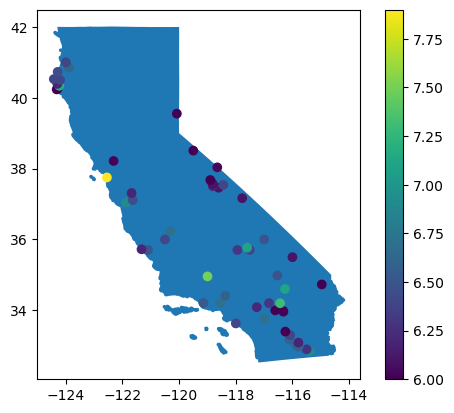

In [7]:
""" Use the CA boundary to clip the earthquakes. """

# convert the CA boundary to the same projection as the earthquakes
ca_boundary_gdf = ca_boundary_gdf.to_crs(usgs_gdf.crs)

# clip the earthquakes to the CA boundary
ca_earthquakes_gdf = gpd.clip(usgs_gdf, ca_boundary_gdf)

# plot the clipped earthquakes and the state boundary
fig, ax = plt.subplots()
ca_boundary_gdf.plot(ax = ax)
ca_earthquakes_gdf.plot(ax = ax, column = "mag", legend=True)
plt.show()


What if we want earthquakes near CA: e.g., within 100 km?  We can inflate (*buffer*) the shapefile boundary to accomplish this.

Note, however, that the shapefile uses a degree-based coordinate system, so we'll *buffer* by degrees, using the fact that 1 degree is approximately 100 km.

/var/folders/0s/yp78v9d15qd8pmgtc3xknpfh37trx3/T/ipykernel_15891/3371180840.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_boundary_inflated = ca_boundary_gdf.buffer(1)


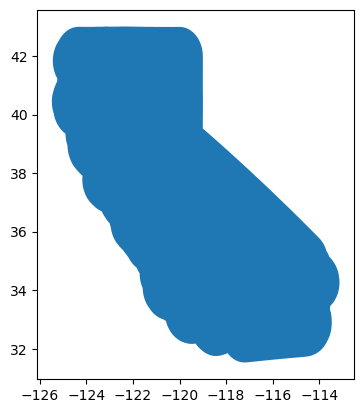

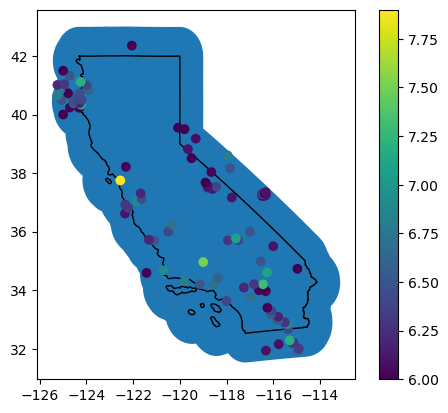

In [8]:
""" Inflate the CA shapefile boundary. """
# inflate the boundary by 5 degrees
ca_boundary_inflated = ca_boundary_gdf.buffer(1)

# plot the inflated boundary
ca_boundary_inflated.plot();

# clip the earthquakes to the inflated boundary
ca_earthquakes_gdf = gpd.clip(usgs_gdf, ca_boundary_inflated)

# plot the clipped earthquakes and the state boundary
fig, ax = plt.subplots()
ca_boundary_inflated.plot(ax = ax) # the inflated shape
ca_boundary_gdf.plot(ax = ax, facecolor="none", edgecolor="black") # the original shape
ca_earthquakes_gdf.plot(ax = ax, column = "mag", legend=True)
plt.show()


In [9]:
""" Save the inflated boundary to a shapefile for later use. """

# save the inflated boundary to a shapefile
ca_boundary_inflated.to_file("ca_inflated.shp.zip", driver = "ESRI Shapefile")



In [10]:
""" Save the clipped earthquakes for later use. """

# convert the date column to a string
ca_earthquakes_gdf_tmp = ca_earthquakes_gdf.copy()
ca_earthquakes_gdf_tmp["time"] = ca_earthquakes_gdf_tmp["time"].astype(str)

# save the clipped earthquakes to a shapefile (there will be a warning about column names; this is OK)
ca_earthquakes_gdf_tmp.to_file("ca_earthquakes.shp.zip", driver = "ESRI Shapefile")

/var/folders/0s/yp78v9d15qd8pmgtc3xknpfh37trx3/T/ipykernel_15891/1127470322.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ca_earthquakes_gdf_tmp.to_file("ca_earthquakes.shp.zip", driver = "ESRI Shapefile")
